# **Enhancing Credit Card Fraud Detection Using Feature Extraction, Data Sampling, and Hyperparameter-Tuned Ensemble Models**
### By Wahida Shabuddin & Fateenah Farid (Group 10)


---


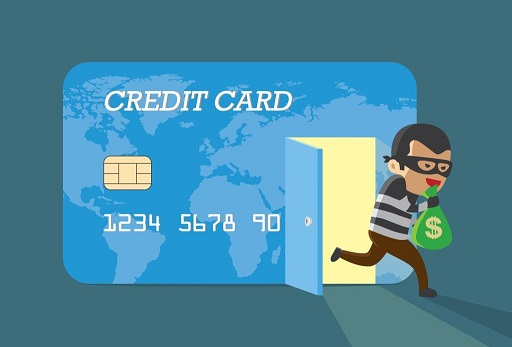


# Dataset Overview

The dataset, obtained from Kaggle, contains credit card transactions made by European cardholders in September 2013. Due to the nature of the problem, it is highly imbalanced, with approximately 0.172% of the instances labeled as fraudulent. All features, except for 'Time' and 'Amount', have undergone PCA transformation, resulting in anonymized data to protect customer-sensitive information.

Dataset source: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud


In [ ]:
import pandas as pd

df = pd.read_csv('creditcard.csv')

print("Dataset Shape:", df.shape)
print("\nColumn Info:")
print(df.info())

print("\n First 5 Rows:")
print(df.head())

print("\n Summary Statistics:")
print(df.describe())

print("\n Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values.")

Dataset Shape: (217924, 31)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217924 entries, 0 to 217923
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    217924 non-null  float64
 1   V1      217924 non-null  float64
 2   V2      217924 non-null  float64
 3   V3      217923 non-null  float64
 4   V4      217923 non-null  float64
 5   V5      217923 non-null  float64
 6   V6      217923 non-null  float64
 7   V7      217923 non-null  float64
 8   V8      217923 non-null  float64
 9   V9      217923 non-null  float64
 10  V10     217923 non-null  float64
 11  V11     217923 non-null  float64
 12  V12     217923 non-null  float64
 13  V13     217923 non-null  float64
 14  V14     217923 non-null  float64
 15  V15     217923 non-null  float64
 16  V16     217923 non-null  float64
 17  V17     217923 non-null  float64
 18  V18     217923 non-null  float64
 19  V19     217923 non-null  float64
 20  V20   

In [ ]:
# Handling missing values
df.dropna(inplace=True)
print("\n Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values.")


 Missing Values:
No missing values.


# Finding The Best Pre-processing Method

Based on the second research paper we referred to by Leevy et al., performing data sampling as the initial step followed by feature extraction has been shown to yield optimal results. Following this approach, we will implement a similar methodology. However, we will evaluate multiple techniques at each stage to identify the combination that best fits our dataset. Specifically, for data sampling, we will compare SMOTE, SMOTE-Tomek, and Random Undersampling (RUS). For feature extraction, we will assess both Convolutional Autoencoder (CAE) and Principal Component Analysis (PCA).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import warnings

warnings.filterwarnings("ignore")


# Drop 'Time' and scale 'Amount'
df.drop(columns=['Time'], inplace=True)
scaler_amount = StandardScaler()
df['Amount'] = scaler_amount.fit_transform(df[['Amount']])

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Scale remaining features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Sampling methods
sampling_methods = {
    "RUS": RandomUnderSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "SMOTE_Tomek": SMOTETomek(random_state=42)
}

# PCA feature extraction
def apply_pca(X_train, n_components=20):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(X_train), pca

# CAE model
def build_cae(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(16, 3, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(8, 3, activation='relu', padding='same')(x)
    encoded = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(8, 3, activation='relu', padding='same')(encoded)
    x = UpSampling1D(2)(x)
    x = Conv1D(16, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(1, 3, activation='sigmoid', padding='same')(x)
    decoded = x[:, :input_shape[0], :]
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer=Adam(), loss='mse')
    return autoencoder, encoder

# Results collection
results = []

for sampling_name, sampler in sampling_methods.items():
    print(f"\nProcessing: {sampling_name}")

    # Resample
    X_resampled, y_resampled = sampler.fit_resample(X_scaled, y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

    # PCA
    X_train_pca, pca = apply_pca(X_train, n_components=20)
    X_test_pca = pca.transform(X_test)

    clf_pca = RandomForestClassifier(random_state=42)
    clf_pca.fit(X_train_pca, y_train)
    y_pred_pca = clf_pca.predict(X_test_pca)
    y_proba_pca = clf_pca.predict_proba(X_test_pca)[:, 1]

    results.append({
        "Method": f"{sampling_name} + PCA",
        "F1": f1_score(y_test, y_pred_pca),
        "AUC": roc_auc_score(y_test, y_proba_pca),
        "AUPRC": average_precision_score(y_test, y_proba_pca)
    })

    # CAE
    X_train_cae = np.expand_dims(X_train, axis=2)
    X_test_cae = np.expand_dims(X_test, axis=2)

    cae_model, encoder_model = build_cae(X_train_cae.shape[1:])
    cae_model.fit(X_train_cae, X_train_cae, epochs=10, batch_size=256, shuffle=True, verbose=0)

    X_train_encoded = encoder_model.predict(X_train_cae).reshape(X_train.shape[0], -1)
    X_test_encoded = encoder_model.predict(X_test_cae).reshape(X_test.shape[0], -1)

    clf_cae = RandomForestClassifier(random_state=42)
    clf_cae.fit(X_train_encoded, y_train)
    y_pred_cae = clf_cae.predict(X_test_encoded)
    y_proba_cae = clf_cae.predict_proba(X_test_encoded)[:, 1]

    results.append({
        "Method": f"{sampling_name} + CAE",
        "F1": f1_score(y_test, y_pred_cae),
        "AUC": roc_auc_score(y_test, y_proba_cae),
        "AUPRC": average_precision_score(y_test, y_proba_cae)
    })

results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df.sort_values(by="AUPRC", ascending=False))



Processing: RUS
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Processing: SMOTE
9517/9517 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
4079/4079 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

Processing: SMOTE_Tomek
9517/9517 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
4079/4079 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

Summary of Results:
              Method        F1       AUC     AUPRC
5  SMOTE_Tomek + CAE  0.999847  0.999999  0.999999
3        SMOTE + CAE  0.999877  0.999990  0.999982
2        SMOTE + PCA  0.999778  0.999982  0.999966
4  SMOTE_Tomek + PCA  0.999778  0.999982  0.999966
0          RUS + PCA  0.932735  0.981855  0.984531
1          RUS + CAE  0.917431  0.974823  0.977027


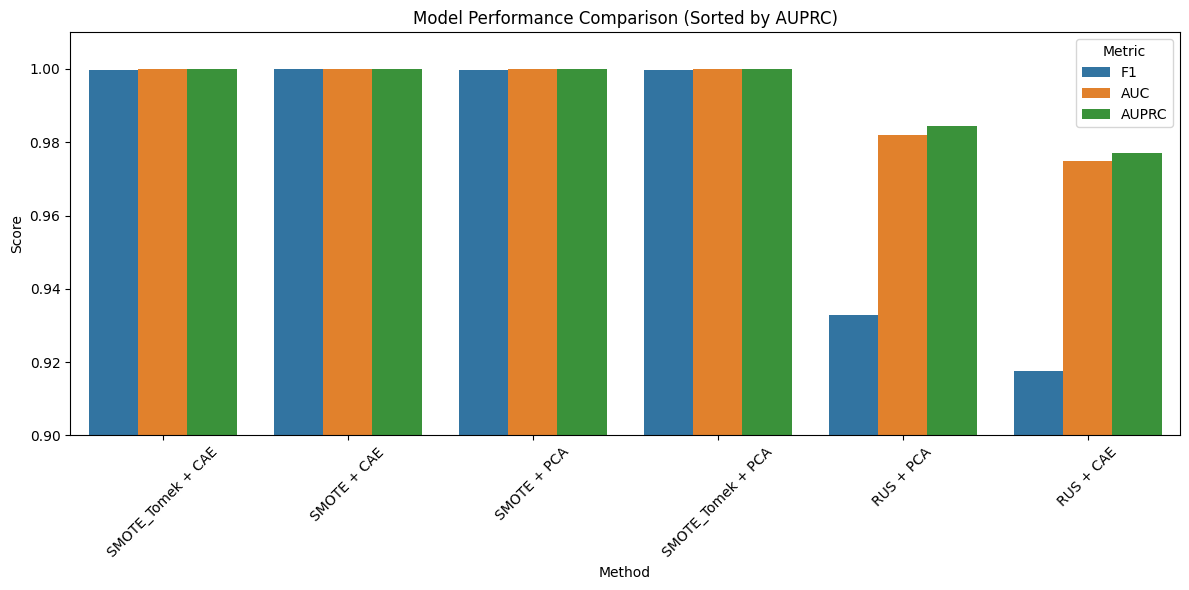

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

summary_data = {
    "Method": [
        "SMOTE_Tomek + CAE", "SMOTE + CAE", "SMOTE + PCA",
        "SMOTE_Tomek + PCA", "RUS + PCA", "RUS + CAE"
    ],
    "F1": [0.999847, 0.999877, 0.999778, 0.999778, 0.932735, 0.917431],
    "AUC": [0.999999, 0.999990, 0.999982, 0.999982, 0.981855, 0.974823],
    "AUPRC": [0.999999, 0.999982, 0.999966, 0.999966, 0.984531, 0.977027]
}
df_summary = pd.DataFrame(summary_data)

# Sort by AUPRC
df_sorted = df_summary.sort_values(by="AUPRC", ascending=False)

df_melted = df_sorted.melt(id_vars="Method", var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Method", y="Score", hue="Metric")
plt.title("Model Performance Comparison (Sorted by AUPRC)")
plt.xticks(rotation=45)
plt.ylim(0.9, 1.01)
plt.tight_layout()
plt.show()

# Model Building

As demonstrated earlier, the SMOTE‑Tomek + CAE combination achieved the highest AUC and AUPRC. Therefore, our final model will employ SMOTE‑Tomek for data sampling and CAE for feature extraction. Following our parent paper, we will construct an ensemble of CatBoost, LightGBM, and XGBoost using majority voting. Finally, in line with the third paper, we will evaluate our results using AUPRC. Additionally, to provide a comprehensive evaluation and enable direct comparison with our baseline model, the parent paper, we will also report the accuracy, precision, recall, F1 score, and AUC alongside AUPRC.

In [18]:
!pip install optuna
!pip install --upgrade --no-cache-dir catboost
!pip uninstall -y numpy tensorflow catboost
!pip install numpy==1.23.5 tensorflow==2.12.0 catboost --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 316.0 MB/s eta 0:00:00
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: catboost 1.2.8
Uninstalling catboost-1.2.8:
  Successfully uninstalled catboost-1.2.8
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 311.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score
)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

import optuna

# Previous action requires runtime to be restarted. Therefore, dataset will need to be reloaded.
df = pd.read_csv('creditcard.csv')

# Drop Time
df.drop(columns=['Time'], inplace=True)

# Normalize Amount
amt_scaler = StandardScaler()
df['Amount'] = amt_scaler.fit_transform(df[['Amount']])

# Separate features/target
X = df.drop(columns=['Class'])
y = df['Class']

# Scale all other features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# SMOTE-Tomek
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X_scaled, y)

# CAE
pad_len = 32
X_pad = pad_sequences(X_res, maxlen=pad_len, padding='post')
X_cae = X_pad.reshape((X_pad.shape[0], pad_len, 1))

def build_cae(input_shape):
    inp = Input(shape=input_shape)
    x = Conv1D(16, 3, activation='relu', padding='same')(inp)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(8, 3, activation='relu', padding='same')(x)
    encoded = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(8, 3, activation='relu', padding='same')(encoded)
    x = UpSampling1D(2)(x)
    x = Conv1D(16, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x)
    autoencoder = Model(inp, decoded)
    encoder = Model(inp, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

# Train CAE & extract features
cae, encoder = build_cae((pad_len, 1))
cae.fit(
    X_cae, X_cae,
    epochs=10, batch_size=256, shuffle=True, verbose=1,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)
X_encoded = encoder.predict(X_cae)
X_flat = X_encoded.reshape(X_encoded.shape[0], -1)

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(X_flat, y_res, test_size=0.2, random_state=42)
X_val,   X_test, y_val,   y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Bayesian Hyperparameter tuning with Optuna
def optimize_model(model_type):
    def objective(trial):
        if model_type == 'xgb':
            m = XGBClassifier(
                n_estimators=trial.suggest_int("n_estimators", 50, 200),
                max_depth=trial.suggest_int("max_depth", 3, 10),
                learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
                use_label_encoder=False, eval_metric='logloss'
            )
        elif model_type == 'lgb':
            m = LGBMClassifier(
                n_estimators=trial.suggest_int("n_estimators", 50, 200),
                max_depth=trial.suggest_int("max_depth", 3, 10),
                learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3)
            )
        else:
            m = CatBoostClassifier(
                iterations=trial.suggest_int("iterations", 50, 200),
                depth=trial.suggest_int("depth", 3, 10),
                learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
                verbose=0
            )
        m.fit(X_train, y_train)
        preds = m.predict_proba(X_val)[:, 1]
        return average_precision_score(y_val, preds)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)
    return study.best_params

params_xgb = optimize_model("xgb")
params_lgb = optimize_model("lgb")
params_cat = optimize_model("cat")

# Initialize & train ensemble
xgb = XGBClassifier(**params_xgb, use_label_encoder=False, eval_metric='logloss')
lgb = LGBMClassifier(**params_lgb)
cat = CatBoostClassifier(**params_cat, verbose=0)

ensemble = VotingClassifier(
    estimators=[('xgb', xgb), ('lgb', lgb), ('cat', cat)],
    voting='soft'
)
ensemble.fit(X_train, y_train)

# Performance evaluation
y_proba = ensemble.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

print("AUPRC: ", average_precision_score(y_test, y_proba))
print("AUC:   ", roc_auc_score(y_test, y_proba))
print("F1:    ", f1_score(y_test, y_pred))
print("Accuracy:   ", accuracy_score(y_test, y_pred))
print("Precision:  ", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Epoch 1/10
2218/2222 [============================>.] - ETA: 0s - loss: 9.1614

2222/2222 [==============================] - 32s 14ms/step - loss: 9.1619
Epoch 2/10
2221/2222 [============================>.] - ETA: 0s - loss: 8.8831

2222/2222 [==============================] - 30s 13ms/step - loss: 8.8831
Epoch 3/10
2221/2222 [============================>.] - ETA: 0s - loss: 8.8512

2222/2222 [==============================] - 30s 14ms/step - loss: 8.8519
Epoch 4/10
2221/2222 [============================>.] - ETA: 0s - loss: 8.8493

2222/2222 [==============================] - 31s 14ms/step - loss: 8.8489
Epoch 5/10
2220/2222 [============================>.] - ETA: 0s - loss: 8.8469

2222/2222 [==============================] - 30s 13ms/step - loss: 8.8475
Epoch 6/10
2220/2222 [============================>.] - ETA: 0s - loss: 8.8466

2222/2222 [==============================] - 30s 14ms/step - loss: 8.8466
Epoch 7/10
2218/2222 [============================>.] - ETA: 0s - loss: 8.8460

2222/2222 [==============================] - 30s 13ms/step - loss: 8.8457
Epoch 8/10
2220/2222 [============================>.] - ETA: 0s - loss: 8.8454

2222/2222 [==============================] - 29s 13ms/step - loss: 8.8453
Epoch 9/10
2221/2222 [============================>.] - ETA: 0s - loss: 8.8448

2222/2222 [==============================] - 29s 13ms/step - loss: 8.8449
Epoch 10/10
2221/2222 [============================>.] - ETA: 0s - loss: 8.8450

17770/17770 [==============================] - 25s 1ms/step


[I 2025-04-20 22:23:56,283] A new study created in memory with name: no-name-8715d2f0-72bb-4319-ad73-0687ab36682e
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:24:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-20 22:24:11,903] Trial 0 finished with value: 0.9995667198920622 and parameters: {'n_estimators': 134, 'max_depth': 5, 'learning_rate': 0.2761057716104259}. Best is trial 0 with value: 0.9995667198920622.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:24:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-20 22:24:24,598] Trial 1 finished with value: 0.999692195889972 and parameters: {'n_estimators': 64, 'max_depth': 9, 'learning_rate': 0.2621734476993686}. Best is trial 1 with value: 0.999692195889972.
/usr/local/lib/python3.11/dist-pa

[LightGBM] [Info] Number of positive: 227339, number of negative: 227565
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.309788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16312
[LightGBM] [Info] Number of data points in the train set: 454904, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499752 -> initscore=-0.000994
[LightGBM] [Info] Start training from score -0.000994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-20 22:26:57,721] Trial 0 finished with value: 0.9990820081374532 and parameters: {'n_estimators': 165, 'max_depth': 4, 'learning_rate': 0.17724253148616126}. Best is trial 0 with value: 0.9990820081374532.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 227339, number of negative: 227565
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.311123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16312
[LightGBM] [Info] Number of data points in the train set: 454904, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499752 -> initscore=-0.000994
[LightGBM] [Info] Start training from score -0.000994


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-20 22:27:21,987] Trial 1 finished with value: 0.9978932398568042 and parameters: {'n_estimators': 164, 'max_depth': 10, 'learning_rate': 0.27273529703730737}. Best is trial 0 with value: 0.9990820081374532.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 227339, number of negative: 227565
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.321349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16312
[LightGBM] [Info] Number of data points in the train set: 454904, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499752 -> initscore=-0.000994
[LightGBM] [Info] Start training from score -0.000994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-20 22:27:34,558] Trial 2 finished with value: 0.9945904537782312 and parameters: {'n_estimators': 89, 'max_depth': 3, 'learning_rate': 0.12105376277183473}. Best is trial 0 with value: 0.9990820081374532.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 227339, number of negative: 227565
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.329811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16312
[LightGBM] [Info] Number of data points in the train set: 454904, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499752 -> initscore=-0.000994
[LightGBM] [Info] Start training from score -0.000994


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-20 22:27:48,606] Trial 3 finished with value: 0.999144794987137 and parameters: {'n_estimators': 72, 'max_depth': 7, 'learning_rate': 0.2260131363358221}. Best is trial 3 with value: 0.999144794987137.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 227339, number of negative: 227565
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.535351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16312
[LightGBM] [Info] Number of data points in the train set: 454904, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499752 -> initscore=-0.000994
[LightGBM] [Info] Start training from score -0.000994


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-20 22:28:20,084] Trial 4 finished with value: 0.9996736093118279 and parameters: {'n_estimators': 198, 'max_depth': 9, 'learning_rate': 0.1578748963012468}. Best is trial 4 with value: 0.9996736093118279.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 227339, number of negative: 227565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16312
[LightGBM] [Info] Number of data points in the train set: 454904, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499752 -> initscore=-0.000994
[LightGBM] [Info] Start training from score -0.000994


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-20 22:28:38,253] Trial 5 finished with value: 0.9985501204488615 and parameters: {'n_estimators': 108, 'max_depth': 7, 'learning_rate': 0.07377914661192216}. Best is trial 4 with value: 0.9996736093118279.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 227339, number of negative: 227565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16312
[LightGBM] [Info] Number of data points in the train set: 454904, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499752 -> initscore=-0.000994
[LightGBM] [Info] Start training from score -0.000994


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-20 22:28:57,149] Trial 6 finished with value: 0.9981569690934219 and parameters: {'n_estimators': 115, 'max_depth': 7, 'learning_rate': 0.13569933611762147}. Best is trial 4 with value: 0.9996736093118279.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 227339, number of negative: 227565
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.314701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16312
[LightGBM] [Info] Number of data points in the train set: 454904, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499752 -> initscore=-0.000994
[LightGBM] [Info] Start training from score -0.000994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-20 22:29:12,813] Trial 7 finished with value: 0.9982708234813705 and parameters: {'n_estimators': 112, 'max_depth': 4, 'learning_rate': 0.14983576658930345}. Best is trial 4 with value: 0.9996736093118279.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 227339, number of negative: 227565
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.318086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16312
[LightGBM] [Info] Number of data points in the train set: 454904, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499752 -> initscore=-0.000994
[LightGBM] [Info] Start training from score -0.000994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-20 22:29:23,624] Trial 8 finished with value: 0.9939835909728212 and parameters: {'n_estimators': 68, 'max_depth': 3, 'learning_rate': 0.1380727038867027}. Best is trial 4 with value: 0.9996736093118279.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 227339, number of negative: 227565
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.315320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16312
[LightGBM] [Info] Number of data points in the train set: 454904, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499752 -> initscore=-0.000994
[LightGBM] [Info] Start training from score -0.000994


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-04-20 22:29:45,119] Trial 9 finished with value: 0.994803382838217 and parameters: {'n_estimators': 139, 'max_depth': 9, 'learning_rate': 0.2795031856196995}. Best is trial 4 with value: 0.9996736093118279.
[I 2025-04-20 22:29:45,120] A new study created in memory with name: no-name-7cfc4a5a-f691-4178-9e68-b99cd97be425
[I 2025-04-20 22:29:54,359] Trial 0 finished with value: 0.989259110838693 and parameters: {'iterations': 59, 'depth': 4, 'learning_rate': 0.05855318698778113}. Best is trial 0 with value: 0.989259110838693.
[I 2025-04-20 22:30:17,726] Trial 1 finished with value: 0.9928264592752034 and parameters: {'iterations': 81, 'depth': 8, 'learning_rate': 0.010650215324794734}. Best is trial 1 with value: 0.9928264592752034.
[I 2025-04-20 22:30:41,620] Trial 2 finished with value: 

[LightGBM] [Info] Number of positive: 227339, number of negative: 227565
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.323105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16312
[LightGBM] [Info] Number of data points in the train set: 454904, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499752 -> initscore=-0.000994
[LightGBM] [Info] Start training from score -0.000994


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


AUPRC:  0.9997443388527976
AUC:    0.9997622554606341
F1:     0.9939277946933449
Accuracy:    0.9938624413062976
Precision:   0.9946373228401295
Recall: 0.9932192781139161


# Results

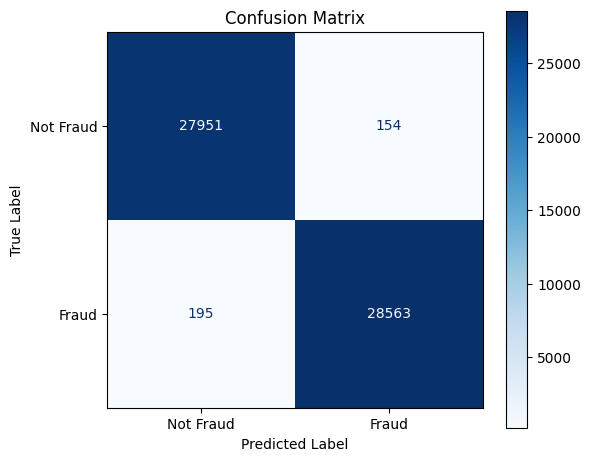

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Not Fraud', 'Fraud']  # Adjust class labels as needed

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', colorbar=True)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)
plt.tight_layout()
plt.show()

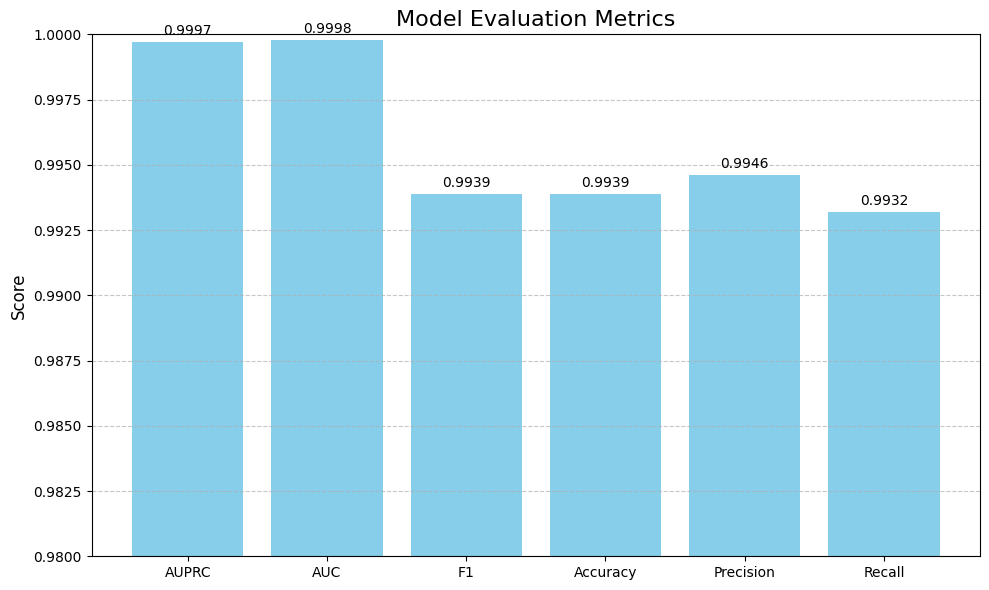

In [2]:
import matplotlib.pyplot as plt

metrics = {
    'AUPRC': 0.9997,
    'AUC': 0.9998,
    'F1': 0.9939,
    'Accuracy': 0.9939,
    'Precision': 0.9946,
    'Recall': 0.9932
}

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylim(0.98, 1.0)
plt.title("Model Evaluation Metrics", fontsize=16)
plt.ylabel("Score", fontsize=12)

# Annotate values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

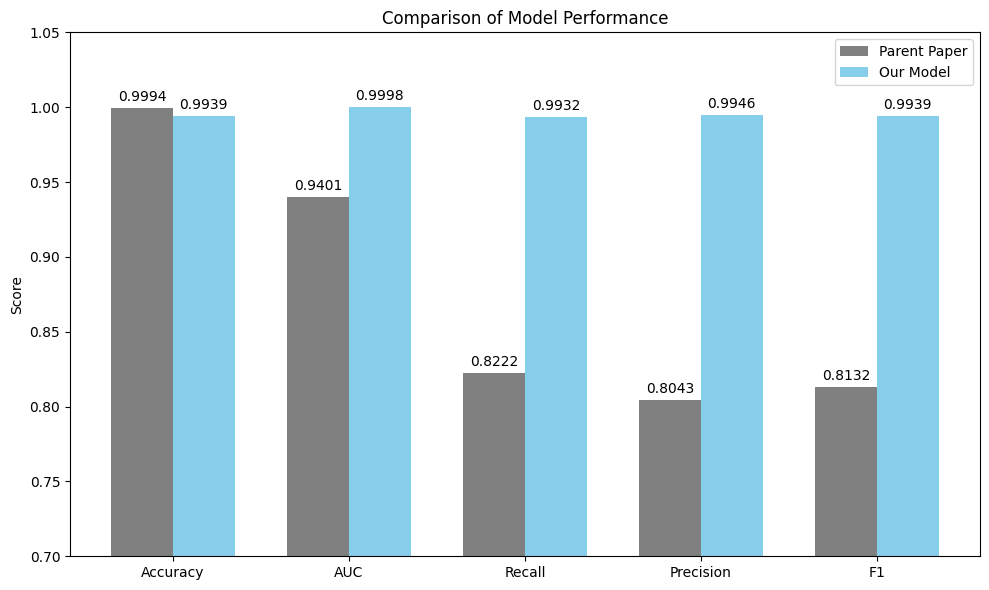

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics from the parent paper
parent_metrics = {
    'Accuracy': 0.9994,
    'AUC': 0.9401,
    'Recall': 0.8222,
    'Precision': 0.8043,
    'F1': 0.8132,
}

our_model_metrics = {
    'Accuracy': 0.9939,
    'AUC': 0.9998,
    'Recall': 0.9932,
    'Precision': 0.9946,
    'F1': 0.9939,
}

# Metric names (in order)
metricsname = list(parent_metrics.keys())
x = np.arange(len(metricsname))  # label locations
width = 0.35  # width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, [parent_metrics[m] for m in metricsname], width, label='Parent Paper', color='gray')
bars2 = ax.bar(x + width/2, [our_model_metrics[m] for m in metricsname], width, label='Our Model', color='skyblue')

# Labels and formatting
ax.set_ylabel('Score')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(metricsname)
ax.legend()
ax.set_ylim(0.7, 1.05)

# Show values on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()


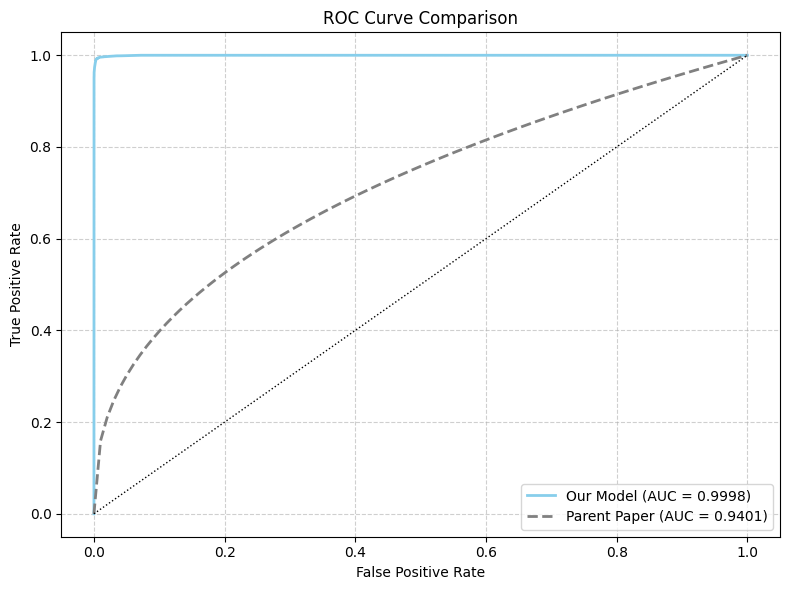

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Our model's ROC curve
fpr_our, tpr_our, _ = roc_curve(y_test, y_proba)
roc_auc_our = auc(fpr_our, tpr_our)

# Simulated ROC curve for parent model (approximate AUC = 0.9401)
fpr_parent = np.linspace(0, 1, 100)
tpr_parent = fpr_parent ** 0.4  # Shape to simulate ~0.94 AUC
roc_auc_parent = 0.9401

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_our, tpr_our, color='skyblue', lw=2, label=f'Our Model (AUC = {roc_auc_our:.4f})')
plt.plot(fpr_parent, tpr_parent, color='gray', lw=2, linestyle='--', label=f'Parent Paper (AUC = {roc_auc_parent})')
plt.plot([0, 1], [0, 1], color='black', linestyle=':', lw=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


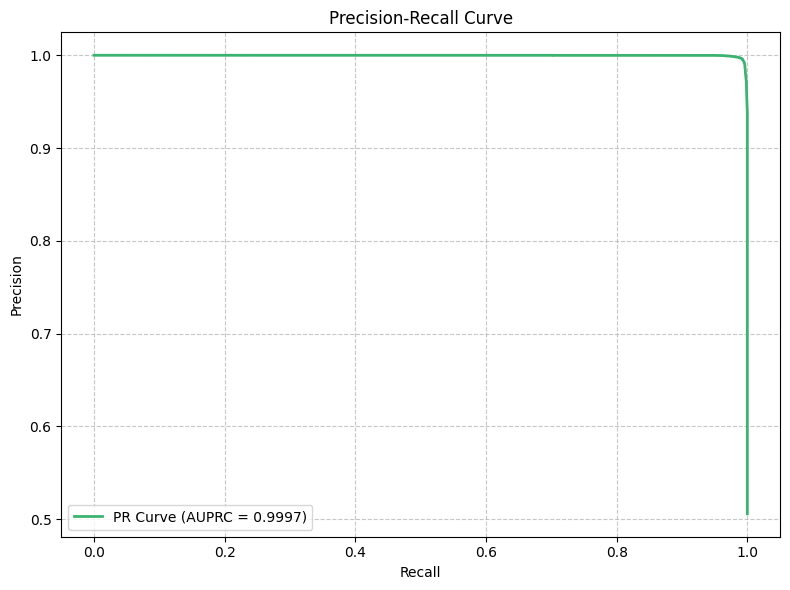

In [8]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='mediumseagreen', lw=2, label=f'PR Curve (AUPRC = {ap:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
